In [104]:
import time
import numpy as np
import random as rd
import math
import os
import torch
from pathlib import Path
import glob
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint,EarlyStopping
from torchmetrics import MeanSquaredError
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
def problem_grouping(clients, time_slot, quad_constr, util_rate=1.5,
                     time_len=6, num_of_util_groups=15):  ##grouping by utility,then by time_slot_length
    num_of_dims = time_slot.shape[0]
    time_slot_min = time_slot.min(axis=1)
    time_slot_av = time_slot.mean(axis=1)
    time_slot_max = time_slot.max(axis=1)
    max_cap = time_slot.max()
    min_av_max_caps = np.concatenate((time_slot_min, time_slot_av, time_slot_max))
    # normalizing time capacities
    min_av_max_caps /= max_cap
    quad_constr /= max_cap
    av_cap_bytime = time_slot.mean(axis=0) / max_cap
    # Normalizing demands in each dimension by min capacity
    for dim in range(num_of_dims):
        clients[:, dim] /= time_slot_min[dim]
    # sum of demands of the first dimension normalized by min capacity of the first dimension
    total_demand = clients[:, 0].sum()
    ##Grouping by utilities
    max_util = clients[:, -2].max()
    min_util = clients[:, -2].min()
    av_util = clients[:, -2].mean()
    if 100 < max_util <= 1200:
        clients[:, -2] /= 10
    elif max_util > 1200:
        clients[:, -2] /= 300
    util_groups = []
    steps = np.zeros(num_of_util_groups)
    steps[0] = util_rate
    for i in range(1, steps.size):
        steps[i] = steps[i - 1] * util_rate
    bool_idx = (clients[:, -2] <= steps[0])
    util_groups.append(clients[np.where(bool_idx)[0]])
    for i in range(1, num_of_util_groups):
        bool_idx = (clients[:, -2] <= steps[i]) & (
                clients[:, -2] > steps[i - 1])
        util_groups.append(clients[np.where(bool_idx)[0]])
    # Normalizing by max_util
    for group in util_groups:
        group[:, -2] /= max_util

    ##Grouping by time_length
    final_groups = []
    gr_time = int(time_slot.shape[1] / time_len)
    for i in range(num_of_util_groups):
        if (util_groups[i].size > 0):
            group_time_lengths = util_groups[i][:, num_of_dims + 1] - util_groups[i][:, num_of_dims]
            min_time_len = np.min(group_time_lengths)
            max_time_len = np.max(group_time_lengths)
            steps = np.linspace(min_time_len, max_time_len, gr_time + 1)
            for j in range(gr_time - 1):
                bool_idx = (group_time_lengths >= steps[j]) & (group_time_lengths < steps[j + 1])
                final_groups.append(util_groups[i][np.where(bool_idx)[0]])
            bool_idx = (group_time_lengths >= steps[-2]) & (group_time_lengths <= steps[-1])
            final_groups.append(util_groups[i][np.where(bool_idx)[0]])
        else:
            for _ in range(gr_time):
                final_groups.append(util_groups[i])
    return final_groups, total_demand, min_av_max_caps, av_cap_bytime, quad_constr, min_util, av_util

In [63]:
def data_preprocess(groups, total_demand, quad_cap, min_av_max_caps, av_cap_bytime,
                    min_util, av_util, num_of_dims=3, num_of_clients=1500, time_length=96):
    length = len(groups)
    inputs = np.zeros((length + 1, 3 * num_of_dims + 1 + time_length + 2))
    labels = np.zeros((length + 1, 2))
    for i, group in enumerate(groups):
        if group.size > 0:
            inputs[i][:num_of_dims] = np.min(group[:, :num_of_dims], axis=0)  # minimum demand per dimension
            inputs[i][num_of_dims:2 * num_of_dims] = np.mean(group[:, :num_of_dims],
                                                             axis=0)  # average demand per dimension
            inputs[i][2 * num_of_dims:3 * num_of_dims] = np.max(group[:, :num_of_dims],
                                                                axis=0)  # maximum demand per dimension
            quadr_demands = ((group[:, :num_of_dims] ** 2).sum(axis=1) / 30000).mean()
            inputs[i][3 * num_of_dims] = quadr_demands
            inputs[i][3 * num_of_dims + 1:3 * num_of_dims + time_length + 1] = np.sum(
                group[:, num_of_dims + 2:num_of_dims + 2 + time_length],
                axis=0) / num_of_clients  # average time_occupancy

            inputs[i][-2] = np.mean(group[:, -2])  # average utility
            inputs[i][-1] = group.shape[0] / num_of_clients  # what part of clients is in this group
            labels[i][0] = np.sum(group[:, -1]) / num_of_clients  # what part is selected in the final answer
            if group[np.where(group[:, -1] == 1)].size > 0:
                labels[i][1] = group[np.where(group[:, -1] == 1)][:,
                               0].sum() / total_demand  # total demand of selected clients/total demand of the first dimension
    inputs[-1][:3 * num_of_dims] = min_av_max_caps
    inputs[-1][3 * num_of_dims] = quad_cap
    inputs[-1][3 * num_of_dims + 1:3 * num_of_dims + time_length + 1] = av_cap_bytime
    inputs[-1][-2] = min_util
    inputs[-1][-1] = av_util
    labels[-1][0] = 1 - labels[:, 0].sum()
    labels[-1][1] = 1 - labels[:, 1].sum()
    return inputs,labels

In [64]:
class DataSetMaker(Dataset):
    def __init__(self):
        self.states=list(glob.glob('states/*.npz'))
    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        state = np.load(self.states[idx])
        clients_list = state['cl']
        time_slot_capacity = state['tslot']
        quad_constr = state['quad_constr']
        f_groups, tot_dem, min_av_max_caps, av_cap_bytime, min_util, av_util, q_c = problem_grouping(clients_list,
                                                                                                 time_slot_capacity,
                                                                                                 quad_constr)
        inputs, labels = data_preprocess(f_groups, tot_dem, q_c, min_av_max_caps, av_cap_bytime,
                               min_util, av_util)
        return np.float32(inputs),np.float32(labels)

In [65]:
dataset=DataSetMaker()

In [66]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [67]:
train_set,valid_set,test_set=random_split(dataset,[3000,406,400])

In [68]:
train_loader = DataLoader(train_set, batch_size=32,shuffle=True,drop_last=True)
val_loader = DataLoader(valid_set, batch_size=1)
test_loader = DataLoader(test_set, batch_size=1)

In [69]:
def scaled_dot_product(q, k, v):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values

In [70]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values = scaled_dot_product(q, k, v)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        
        return o

In [71]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Attention part
        attn_out = self.self_attn(x)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [72]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [73]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [74]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes),
            nn.ReLU(inplace=True)
        )

    def forward(self, x,add_positional_encoding=False):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x)
        x = self.output_net(x)
        x = F.softmax(x, dim=-2)
        #x = F.softmax(x, dim=1)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.hparams.warmup,
                                             max_iters=self.hparams.max_iters)
        
        return [optimizer], [{'scheduler': lr_scheduler,
                              'interval': 'epoch'}]

        
    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError
        
    def on_train_epoch_end(self):
        raise NotImplementedError

In [125]:
class  KnapsackPredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        inp_data, labels = batch
        # Perform prediction and calculate loss and accuracy
        #scaling_factors=torch.tensor([10,1],device=device)
        preds = self.forward(inp_data)
        loss1 = F.l1_loss(preds[:,:,0],labels[:,:,0])
        loss2 = F.l1_loss(preds[:,:,1],labels[:,:,1])
        loss=loss1+loss2
        # Logging
        self.log(f"{mode}_loss",loss)
        self.log(f"{mode}_loss1",loss1)
        self.log(f"{mode}_loss2",loss2)
        return loss


    def training_step(self, batch, batch_idx):
        loss= self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")
        
    def on_train_epoch_end(self):
        batch = next(iter(train_loader))
        x, _ = batch
        x=x.to(device)
        # Forward pass to get predictions
        predictions = self.forward(x)
        
        # Print predictions
        print("Predictions:", predictions[[-1]].to('cpu').detach().numpy())

In [76]:
CHECKPOINT_PATH="C:\\Users\\zhira\\CSIE_PYTHON_PROJECTS\\UFP_FINAL"

In [77]:
def train_knapsack(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "UfpCheckPoint")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(callbacks=[ModelCheckpoint(dirpath=root_dir,filename='UfpCheckPoint',save_weights_only=True, mode="min", monitor="val_loss"),
                                    LearningRateMonitor(logging_interval='epoch'),
                                    EarlyStopping(monitor="val_loss", min_delta=1e-6, patience=20, verbose=False, mode="min")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=150,
                         gradient_clip_val=1,
                         log_every_n_steps=10)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(root_dir, "UfpCheckPoint.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = KnapsackPredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = KnapsackPredictor(max_iters=trainer.max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad}")

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=1)
    test_result = trainer.test(model, test_loader, verbose=1)

    model = model.to(device)
    return model

In [79]:
knapsack_model =                  train_knapsack(input_dim=108,
                                                 model_dim=150,
                                                 num_heads=2,
                                                 num_classes=2,
                                                 num_layers=2,
                                                 dropout=0.0,
                                                 lr=1e-4,
                                                 warmup=20)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.000873055134434253    │
│        test_loss1         │  0.00039693727740086615   │
│        test_loss2         │   0.0004761175368912518   │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0008958101971074939   │
│        test_loss1         │  0.00040719498065300286   │
│        test_loss2         │   0.0004886150127276778   │
└───────────────────────────┴───────────────────────────┘

In [80]:
inps,labs=test_set.__getitem__(0)

In [82]:
inps=torch.from_numpy(np.float32(inps[None,:])).to(device)

In [90]:
pred=knapsack_model(inps)

In [91]:
pred.shape

torch.Size([1, 241, 2])

In [92]:
lab.shape

(241, 2)

In [93]:
pred=pred.cpu().detach().numpy().squeeze()

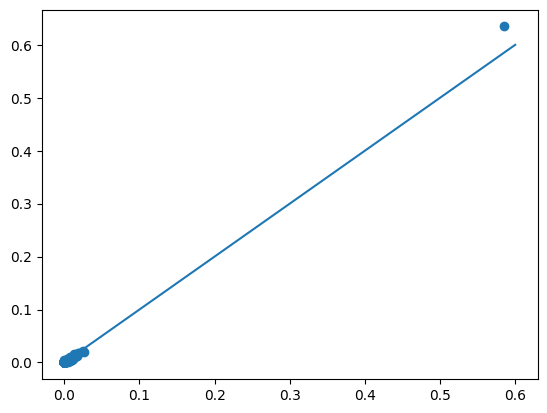

In [95]:
plt.scatter(pred[:,0],labs[:,0])
plt.plot([0,0.6],[0,0.6])

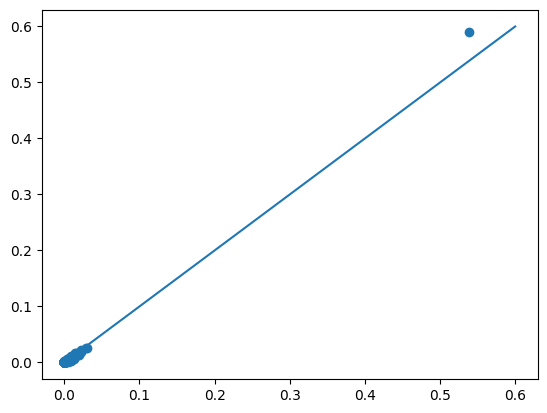

In [97]:
plt.scatter(pred[:,1],labs[:,1])
plt.plot([0,0.6],[0,0.6])

In [98]:
def selection_algorithm(clients_list,time_slot,groups,total_demand,y_pred):
    num_of_changes=10
    num_of_dims=time_slot.shape[0]
    if type(y_pred)!=np.ndarray:
        prediction=y_pred.cpu().detach().numpy()
    else:
        prediction=y_pred
    length=clients_list.shape[0]
    time_length=time_slot.shape[1]
    time_slot_min=np.zeros(num_of_dims)
    for dim in range(num_of_dims):
        time_slot_min[dim]=time_slot[dim].min()
    sum_demands=prediction[:,1]*total_demand #(total_demand)<-total demand of selected items in the first dimension
    violated_total_utility=0
    violated_selected_items=[]
    final_total_utility=0
    final_selected_items=[]
    for step in range(100):
        total_utility=0
        selected_items=[]
        for i,group in enumerate(groups):
            if(group.size>0):
                max_res=0
                best_vec=np.array([])
                curr_demand=0
                group_util_sum=np.sum(group[:,-2])
                #prob_vec=np.array([item[-2]/group_util_sum for item in group])
                prob_vec_uniform=np.ones(group.shape[0])/group.shape[0]
                for _ in range(10):
                    sel_size=min(math.ceil(prediction[i][0]*length),group.shape[0])
                    selection=np.random.choice(range(group.shape[0]),sel_size,replace=False,p=prob_vec_uniform)
                    sel_vec=group[selection]
                    util_sum=np.sum(sel_vec[:,-2])
                    d_sum=np.sum(sel_vec[:,0]) #total demand of selected items in the first dimension
                    if np.abs(d_sum-sum_demands[i])<=0.1*sum_demands[i] and util_sum>max_res:
                        max_res=util_sum
                        best_vec=sel_vec
                        curr_demand=d_sum
                if best_vec.size>0:
                    total_utility+=max_res
                    for item in best_vec:
                        selected_items.append(item)
        is_correct=np.stack([sum([selected_items[index][dim]*time_slot_min[dim]*selected_items[index][num_of_dims+1+time] for index in range(len(selected_items))])<=time_slot[dim][time-1]
                                                  for dim in range(num_of_dims) for time in range(1,time_length+1)])
        if all(is_correct):
            if final_total_utility<total_utility:
                final_selected_items=selected_items.copy()
                final_total_utility=total_utility
        else:
            if violated_total_utility<total_utility:
                violated_selected_items=selected_items.copy()
                violated_total_utility=total_utility
                correct=np.copy(is_correct)
    if final_total_utility>0:
        return np.stack(final_selected_items),final_total_utility
    while not all(correct):
            min_utility=2
            min_item_index=0
            indices=np.where(correct==False)[0]
            dims_f=indices%6
            times_f=indices//6+1
            time_indices=num_of_dims+1+times_f
            for item in range(len(violated_selected_items)):
                x=violated_selected_items[item]
                if any(x[time_indices]==1):
                    if(x[-2]<min_utility):
                        min_utility=x[-2]
                        min_item_index=item
            violated_selected_items.pop(min_item_index)
            violated_total_utility=sum([item[-2] for item in violated_selected_items])
            correct=np.stack([sum([violated_selected_items[index][dim]*time_slot_min[dim]*violated_selected_items[index][num_of_dims+1+time] for index in range(len(violated_selected_items))])<=time_slot[dim][time-1]
                                              for dim in range(num_of_dims) for time in range(1,time_length+1)])
            if all(correct):
                break
    return np.stack(violated_selected_items),violated_total_utility

In [99]:
def selection_algorithm2(clients_list,time_slot,groups,total_demand,y_pred):
    if type(y_pred)!=np.ndarray:
        prediction=y_pred.cpu().detach().numpy()
    else:
        prediction=y_pred
    num_of_dims=time_slot.shape[0]
    length=clients_list.shape[0]
    time_length=time_slot.shape[1]
    time_slot_min = time_slot.min(axis=1)
    
    sum_demands=prediction[:,1]*total_demand #(total_demand)<-total demand of selected items in the first dimension
    final_total_utility=0
    final_selected_items=[]
    for step in range(100):
        total_utility=0
        selected_items=[]
        for i,group in enumerate(groups):
            if(group.size>0):
                max_res=0
                best_vec=np.array([])
                curr_demand=0
                group_util_sum=np.sum(group[:,-2])
                #prob_vec=np.array([item[-2]/group_util_sum for item in group])
                prob_vec_uniform=np.ones(group.shape[0])/group.shape[0]
                for _ in range(10):
                    sel_size=min(math.ceil(prediction[i][0]*length),group.shape[0])
                    selection=np.random.choice(range(group.shape[0]),sel_size,replace=False,p=prob_vec_uniform)
                    sel_vec=group[selection]
                    util_sum=np.sum(sel_vec[:,-2])
                    d_sum=np.sum(sel_vec[:,0]) #total demand of selected items in the first dimension
                    if util_sum>max_res and np.abs(d_sum-sum_demands[i])<=0.1*sum_demands[i]:#0.05
                        max_res=util_sum
                        best_vec=sel_vec
                        curr_demand=d_sum
                if best_vec.size>0:
                    total_utility+=max_res
                    selected_items.extend(best_vec)
                    
        is_correct=np.stack([sum([selected_items[index][dim]*time_slot_min[dim]*selected_items[index][num_of_dims+1+time] for index in range(len(selected_items))])<=time_slot[dim][time-1]
                                                  for dim in range(num_of_dims) for time in range(1,time_length+1)])
        while not all(is_correct) and total_utility>final_total_utility:
            min_utility=2
            min_item_index=0
            indices=np.where(is_correct==False)[0]
            dims_f=indices%6
            times_f=indices//6+1
            time_indices=num_of_dims+1+times_f
            for item in range(len(selected_items)):
                x=selected_items[item]
                if any(x[time_indices]==1):
                    if(x[-2]<min_utility):
                        min_utility=x[-2]
                        min_item_index=item
            selected_items.pop(min_item_index)
            total_utility=sum([item[-2] for item in selected_items])
            is_correct=np.stack([sum([selected_items[index][dim]*time_slot_min[dim]*selected_items[index][num_of_dims+1+time] for index in range(len(selected_items))])<=time_slot[dim][time-1]
                                              for dim in range(num_of_dims) for time in range(1,time_length+1)])
            if all(is_correct):
                break
        if final_total_utility<total_utility:
            final_selected_items=selected_items.copy()
            final_total_utility=total_utility
    return np.stack(final_selected_items),final_total_utility

In [100]:
def selection_algorithm3(clients_list, time_slot, groups, total_demand, y_pred):
    if type(y_pred) != np.ndarray:
        prediction = y_pred.cpu().detach().numpy()
    else:
        prediction = y_pred

    num_of_dims = time_slot.shape[0]
    length = clients_list.shape[0]
    time_length = time_slot.shape[1]
    time_slot_min = time_slot.min(axis=1)
    
    sum_demands = prediction[:, 1] * total_demand 

    final_total_utility = 0
    final_selected_items = []

    for _ in range(10):
        total_utility = 0
        selected_items = []
        rand_perm = np.random.permutation(len(groups))
        
        for gr_num in rand_perm:
            group = groups[gr_num]
            if group.size > 0:
                max_res = 0
                best_vec = np.array([])

                sel_size = min(math.ceil(prediction[gr_num][0] * length), group.shape[0])
                indexes = set(range(sel_size))
                chosen = set()
                invalid_indices = set()

                for _ in range(10):
                    sel_vec = []

                    for index in range(sel_size):
                        for _ in range(10):
                            available_indexes = list(indexes - chosen - invalid_indices)
                            if not available_indexes:
                                break
                            
                            choice = np.random.choice(available_indexes)
                            
                            curr_item = group[choice]
                            temp_selected_items = selected_items + [curr_item]

                            sums = np.array([sum([item[dim] * time_slot_min[dim] * item[num_of_dims + 1 + time] for item in temp_selected_items])
                                             for dim in range(num_of_dims) for time in range(1, time_length + 1)])

                            is_correct = sums <= time_slot[:,:time_length].flatten()

                            if all(is_correct):
                                sel_vec.append(curr_item)
                                chosen.add(choice)
                                break
                            else:
                                invalid_indices.add(choice)

                    if sel_vec:
                        sel_vec = np.array(sel_vec)
                        util_sum = sel_vec[:, -2].sum()
                        d_sum = sel_vec[:, 0].sum()

                        if util_sum > max_res and np.abs(d_sum - sum_demands[gr_num]) <= 0.2 * sum_demands[gr_num] :
                            max_res = util_sum
                            best_vec = sel_vec

                if best_vec.size > 0:
                    total_utility += max_res
                    selected_items.extend(best_vec)

        if final_total_utility < total_utility:
            final_total_utility = total_utility
            final_selected_items = selected_items

    return np.stack(final_selected_items), final_total_utility

In [101]:
states=list(glob.glob('states/*.npz'))

In [110]:
answer=list(glob.glob('answers/*.npy'))

In [102]:
nums=len(states)

In [118]:
def func(idx):
    state = np.load(states[idx])
    clients_list = state['cl']
    time_slot_capacity = state['tslot']
    quad_constr = state['quad_constr']
    f_groups, tot_dem, min_av_max_caps, av_cap_bytime, min_util, av_util, q_c = problem_grouping(clients_list,
                                                                                             time_slot_capacity,
                                                                                             quad_constr)
    inputs, labels = data_preprocess(f_groups, tot_dem, q_c, min_av_max_caps, av_cap_bytime,
                           min_util, av_util)
    ans=np.load(answer[idx])
    return clients_list,time_slot_capacity,f_groups,tot_dem,np.float32(inputs),np.float32(labels),ans

In [119]:
clients_list,time_slot,groups,total_demand,inp,lab,ans=func(100)
inp=torch.from_numpy(np.float32(inp[None,:])).to(device)
pred=knapsack_model(inp)
y_pred=pred.cpu().detach().numpy().squeeze()
start=time.time()
sel_it,util=selection_algorithm(clients_list,time_slot,groups,total_demand,y_pred)
print(time.time()-start)

13.500040292739868
